In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='3'

## Data import

In [30]:
data_import = pd.read_csv('../Data/SQLout_employees.csv')

In [31]:
data2018ft = data_import.query('arrangement == "FT" & year==2018', inplace=False )[['nace', 
                          'esize_class', 'gender', 
                          'age_class', 'lpk',  'education','experience', 'hourly_rate' ]]
data=data2018ft.copy()
data = data.rename(columns={'hourly_rate': 'target'})
data.shape

(36785, 8)

In [32]:
def outlier_iqr_upper(x, n=1.5):
    """ check if x is outlier using IQR"""
    iqr = x.quantile(0.75)-x.quantile(0.25)
    upper_lim = x.quantile(0.75)+iqr*n
    return x>=upper_lim

In [33]:
data['lpk2'] = data['lpk'] // 10
data['outlier'] = data.groupby('lpk2')['target'].apply(outlier_iqr_upper, n=1.0)
data=data.query('outlier==False')
data = data.drop(columns=['outlier', 'lpk2'])
data['lpk'] = data['lpk'].apply(str)

In [34]:
print(data.shape)
data.head()


(34259, 8)


,nace,esize_class,gender,age_class,lpk,education,experience,target
44952,C,1_49,M,50-59,722,G2,13,8.13
44953,C,1_49,M,40-49,721,G2,13,8.20
44954,C,1_49,M,50-59,722,G2,13,8.20
44955,C,1_49,F,40-49,334,G2,0,2.51
44956,M,50_249,F,40-49,522,G2,18,2.19


## Spliting of dataframes for training, validation and testing

In [35]:
train, val, test = np.split(data.sample(frac=1), [int(0.7*len(data)), int(0.8*len(data))])
print(train.shape, val.shape, test.shape)

(23981, 8) (3426, 8) (6852, 8)


## Preprocessing functions
Based on: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers#create_compile_and_train_the_model

In [36]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value.to_numpy()[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

### Normalization of numeric features

In [37]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

### Encoding of string features

In [38]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

## Preprocessing

In [60]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [61]:
all_inputs = []
encoded_features = []

In [62]:
# Numerical features.
for header in ['experience']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [63]:
categorical_cols = ['nace', 'esize_class', 'gender', 'age_class', 'education', 'lpk']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

# Model and predictions

In [64]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(60, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [66]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,
    patience=10, 
    restore_best_weights=True,
)

In [67]:
history = model.fit(train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping],
    verbose=0)

/home/edvinas/miniconda3/envs/tf/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Minimum validation loss: 4.821390151977539


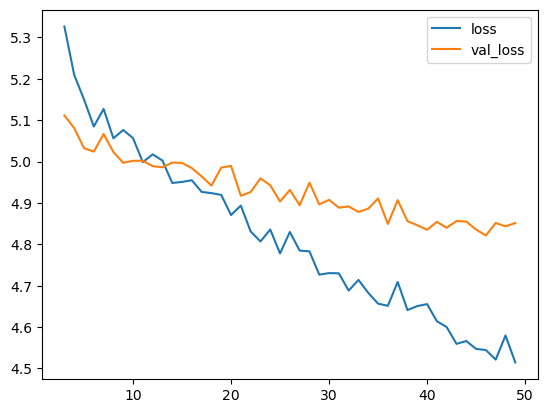

In [68]:
history_df = pd.DataFrame(history.history)
history_df.loc[3:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [70]:
loss, rmse = model.evaluate(test_ds)
print("RMSE", rmse)

27/27 [==============================] - 0s 9ms/step - loss: 4.1598 - root_mean_squared_error: 2.0396
RMSE 2.0395584106445312
